# ¿Qué es `statsmodels`?

https://github.com/dukebody/pycones-statsmodels

*Statistics in Python*

*Statsmodels is a Python module that allows users to explore data, estimate statistical models, and perform statistical tests.*

Por Miquel Camprodon (Kernel Analytics) e Israel Saeta (Lead Ratings)

<img src="http://www.bigdatabcn.com/wp-content/uploads/2015/02/logo_kernel.jpg" style="width:300px; display:inline">
<img src="http://lead-ratings.com/wp-content/uploads/2015/02/Lead-Ratings-eficiencia-leads.jpg" style="width:300px; display:inline">

## Avances respecto a scikit-learn

 - Orientación mucho más académica, estadística/econométrica, menos Machine Learning. (permite ver análisis de modelos y datos)
 - Modelos lineales más avanzados, decenas de tests estadísticos. Lo que echas de menos si vienes de `R`.
 - Muy buena integración con `Pandas` a través de `patsy`:
   - Permite usar DFs directamente
   - Mantiene nombre de variables en la regresión
   - Tratamiento automático sencillo de variables categóricas.

## Desventajas

 - Hay que tener conocimientos estadísticos para sacarle el máximo provecho.
 - Desarrollo más lento que `scikit-learn`. ¡Última versión de diciembre de 2014!
 - Documentación incompleta, difícil de entender. Varias formas de hacer la misma cosa.
 - No diseñado para producción. No hay pipes, ni especial dedicación a performance.


# Aprendamos con un ejemplo

Salarios anuales en consultora informática.

Objetivo: predecir el salario en función de tres variables:
 - `Experience`: Años de experiencia (continua)
 - `Education `: Nivel de educación (categórica, Bachelor, Master, PhD)
 - `Management`: Si el puesto es de jefe o no (categórica/binaria)

In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # gráficos bonitos y avanzados

In [49]:
df = pd.read_csv('data/salary.csv')
df.head()

,Salary,Experience,Education,Management
0,13876,1,Bachelor,True
1,11608,1,PhD,False
2,18701,1,PhD,True
3,11283,1,Master,False
4,11767,1,PhD,False


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 45
Data columns (total 4 columns):
Salary        46 non-null int64
Experience    46 non-null int64
Education     46 non-null object
Management    46 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 1.5+ KB


/home/dukebody/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


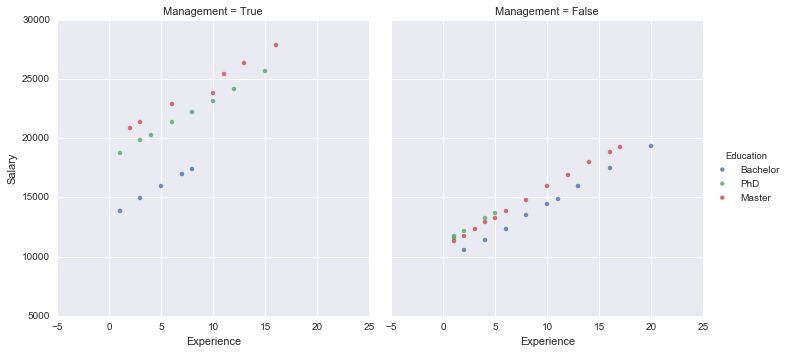

In [51]:
sns.lmplot("Experience", "Salary", hue="Education", col='Management', data=df, fit_reg=False)

Introducimos una variable que no aporta nada por demostración.

In [52]:
df['Random'] = np.random.rand(len(df))

# Regresión lineal con `scikit-learn`

**Primero tenemos que transformar todas las variables en numéricas. Education es un string categórico, utilizamos dummification.**

In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
skl_df = df.copy()
skl_df['Education'] = LabelEncoder().fit_transform(skl_df['Education'])

In [54]:
df_x = skl_df[['Experience', 'Education', 'Management', 'Random']]
onehot = OneHotEncoder(categorical_features=[1], sparse=False)
x = onehot.fit_transform(df_x)
y = skl_df['Salary'].values
print(x[:10])  # primeros registros

[[ 1.          0.          0.          1.          1.          0.0331457 ]
 [ 0.          0.          1.          1.          0.          0.15848547]
 [ 0.          0.          1.          1.          1.          0.72326666]
 [ 0.          1.          0.          1.          0.          0.76468073]
 [ 0.          0.          1.          1.          0.          0.17828219]
 [ 0.          1.          0.          2.          1.          0.95658766]
 [ 0.          1.          0.          2.          0.          0.94080121]
 [ 1.          0.          0.          2.          0.          0.48360706]
 [ 0.          0.          1.          2.          0.          0.80993636]
 [ 0.          1.          0.          3.          0.          0.79796351]]


In [55]:
onehot.feature_indices_  # índice donde empieza cada columna dummificada

array([0, 3])

In [56]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(x, y)

/home/dukebody/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**¿Cómo de bueno es el ajuste en el conjunto de entrenamiento?**

$$R^2 \equiv 1 - {SS_{\rm res}\over SS_{\rm tot}}.\,$$

In [57]:
print('Coeficientes: %s \n' % regr.coef_)
print('Ordenada en el origen: %s \n' % regr.intercept_)
print('%% varianza explicada (R²): %.3f' % regr.score(x, y))

Coeficientes: [-1878.03780841   978.26884768   899.76896073   553.31543473  6917.512786
   930.41685662] 

Ordenada en el origen: 9580.36167465 

% varianza explicada (R²): 0.959


## Problemas
 - Mapping manual de coeficientes. ¿¿Cuál corresponde a cada valor de educación??
 - ¿Significancia de los mismos? ¿Hay alguna variable que no valga para mucho?
 - Incorporar interacciones (no lineales) entre variables no es sencillo.

### Mapping de coeficientes. Una opción a partir de patsy

 - Con scikit, la matriz de análisis es una matriz numérica que no tiene columnas
 - Usando OneHotEncoder / DictVectorizer hay que eliminar posteriormente una columna por cada variable dummificada
 - Necesitamos mantener la traza de a qué corresponde cada columna
 - Patsy nos puede ayudar

## Patsy

<img src="http://i.imgur.com/oDkrZoA.gif">

Biblioteca para describir modelos estadísticos, especialmente lineales.

 - Genera las matrices de números con las que entrenar / predecir (model matrices)
 - Sintaxis simbólica de fórmulas muy similar a la de `R`
 - Funciona bien con variables categóricas (contrast ajustable) [hace la dummyficación automáticamente, de forma inteligente. En sklearn hay que usar `LabelEncoder` (inconsistent API!) + `OneHotEncoder`]

## Fórmulas básicas en patsy
 - **`y ~	x`**: `y` es la variable de respuesta (endógena) que depende de la de entrada `x` (exógena)
 - **`y ~ x1 + x2`**: función de dos variables
 - **`y ~ x1:x2`**: función de la interacción entre las variables `x1` y `x2` (multiplicación)
 - **`y ~ x1*x2`**: atajo para `y ~ x1 + x2 + x1:x2`
 - **`y ~ x * * 2` **: función del cuadrado de `x`.
 - **`y ~ C(x)`**: tomar `x` como variable categórica. Automático si es un string.
 - **`y ~ standardize(x)`**: transformaciones arbitrarias de las variables (p. ej. estandarización)

** Ejemplo anterior usando patsy **

In [58]:
# 'Importamos el modulo dmatrices de la libreria patsy'
from patsy import dmatrices

In [59]:
# esto es lo que teníamos anteriormente
print('Coeficientes del modelo: %s \n' % regr.coef_)
print('Detalle de las variables predictivas \n')
x[0:5]

Coeficientes del modelo: [-1878.03780841   978.26884768   899.76896073   553.31543473  6917.512786
   930.41685662] 

Detalle de las variables predictivas 



array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.0331457 ],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.15848547],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  1.        ,
         0.72326666],
       [ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.76468073],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.17828219]])

In [60]:
print('Detalle del DataFrame \n')
print(skl_df.head())

Detalle del DataFrame 

   Salary  Experience  Education Management    Random
0   13876           1          0       True  0.033146
1   11608           1          2      False  0.158485
2   18701           1          2       True  0.723267
3   11283           1          1      False  0.764681
4   11767           1          2      False  0.178282


Con patsy hemos llegado a tener la matriz de modelización con la ventaja que sigue siendo un objeto `DataFrame`
Ahora tenemos el DataFrame listo para modelizar y además conserva el nombre de las columnas
Vemos que `patsy` ha añadido una columna `Intercept`. Lo tendremos en cuenta a la hora de modelizar

In [61]:
# Usamos una formula y la libreria patsy
formula = 'Salary ~ Experience + C(Education) + Management + Random'
y_patsy, x_patsy = dmatrices(formula, skl_df, return_type="dataframe")

print('Variables exógenas usando patsy \n')
print(x_patsy.head())
print('\n')
print('Variable endógena usando patsy \n')
print(y_patsy.head())

Variables exógenas usando patsy 

   Intercept  C(Education)[T.1]  C(Education)[T.2]  Management[T.True]  \
0          1                  0                  0                   1   
1          1                  0                  1                   0   
2          1                  0                  1                   1   
3          1                  1                  0                   0   
4          1                  0                  1                   0   

   Experience    Random  
0           1  0.033146  
1           1  0.158485  
2           1  0.723267  
3           1  0.764681  
4           1  0.178282  


Variable endógena usando patsy 

   Salary
0   13876
1   11608
2   18701
3   11283
4   11767


** Ajuste del modelo con patsy **

In [62]:
regr2 = LinearRegression(fit_intercept=False)
regr2.fit(x_patsy, y_patsy)

/home/dukebody/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

** Es un modelo parecido? **

In [63]:
print('Coeficientes: %s \n' % regr2.coef_)
print('Ordenada en el origen: %s \n' % regr2.coef_[0][0])
print('%% varianza explicada (R²): %.3f' % regr2.score(x_patsy, y_patsy))

Coeficientes: [[ 7702.32386623  2856.30665609  2777.80676915  6917.512786     553.31543473
    930.41685662]] 

Ordenada en el origen: 7702.32386623 

% varianza explicada (R²): 0.959


** Ahora sabemos que es cada variable ya que son columnas del `DataFrame` **

In [64]:
for val, col in zip(regr2.coef_[0], x_patsy.columns):
    print('%s \t %s' % (val, col))

7702.32386623 	 Intercept
2856.30665609 	 C(Education)[T.1]
2777.80676915 	 C(Education)[T.2]
6917.512786 	 Management[T.True]
553.31543473 	 Experience
930.416856618 	 Random


** Resumen **

Con la ayuda de la libreria `patsy`, somos capaces de realizar la dummificación de variables
de forma sencilla y manteniendo un objeto `DataFrame`, lo que nos permite seguir manteniendo
el nombre de las columnas.

La dummification de variables de `patsy` añade por defecto una columna adicional correspondiente 
al intercept del modelo. Hay que evitar tener duplicidades de este valor, pues la regresión
también considera un intercept adicional. Dos opciones:

 - Indicar a `patsy` que no cree la columna intercept (añadiendo un 0 en la formula del modelo)
 - Indicar al modelo que no use un intercept (atributo `fit_intercept = False`)

## Problemas
 - ~~Mapping manual de coeficientes. ¿¿Cuál corresponde a cada valor de educación??~~ RESUELTO
 - ¿Significancia de los mismos? ¿Hay alguna variable que no valga para mucho?
 - Incorporar interacciones (no lineales) entre variables no es sencillo.

### Significancia de las variables

 - `scikit-learn` no es una librería estadística, es una librería de Machine Learning. 
 - `statsmodels` es una librería estadística y nos va a ayudar, ya que aporta más información sobre los modelos

# `statsmodels`

** Modelizando con `statsmodels` y `patsy` **

In [65]:
import statsmodels.api as sm
from patsy import dmatrices

In [66]:
formula = 'Salary ~ Experience + C(Education) + Management + Random'
y, x = dmatrices(formula, df, return_type='dataframe')
print(x.head())

   Intercept  C(Education)[T.Master]  C(Education)[T.PhD]  Management[T.True]  \
0          1                       0                    0                   1   
1          1                       0                    1                   0   
2          1                       0                    1                   1   
3          1                       1                    0                   0   
4          1                       0                    1                   0   

   Experience    Random  
0           1  0.033146  
1           1  0.158485  
2           1  0.723267  
3           1  0.764681  
4           1  0.178282  


In [67]:
lm = sm.OLS(y, x).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     187.4
Date:                Sat, 21 Nov 2015   Prob (F-statistic):           1.21e-26
Time:                        10:47:30   Log-Likelihood:                -380.37
No. Observations:                  46   AIC:                             772.7
Df Residuals:                      40   BIC:                             783.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept               7702

In [68]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Education),2,1.091346e+08,5.456732e+07,53.267350,5.277038e-12
Management,1,5.105843e+08,5.105843e+08,498.420496,3.411150e-24
Experience,1,3.380979e+08,3.380979e+08,330.043320,6.279723e-21
Random,1,2.304532e+06,2.304532e+06,2.249631,1.414986e-01
Residual,40,4.097619e+07,1.024405e+06,NaN,NaN


La variable "Random" no aporta prácticamente nada al modelo.

**Análisis de los residuos. Deberían estar distribuidos de forma aleatoria en torno a 0.**

/home/dukebody/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


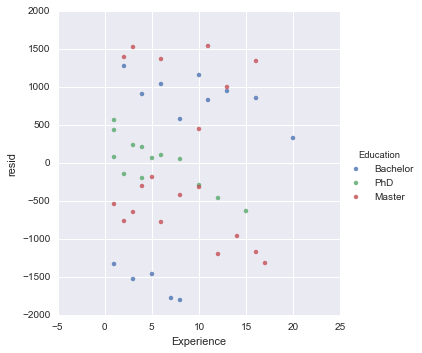

In [69]:
df['resid'] = lm.resid
sns.lmplot("Experience", "resid", hue="Education", data=df, fit_reg=False)

**¿Quizá la educación se valora de forma distinta para los jefes?**

In [70]:
# equivale 'Salary ~ Experience:C(Education) + Experience + C(Education) + C(Management)'
formula_EM = 'Salary ~ Experience + C(Management)*C(Education)'
y, x = dmatrices(formula_EM, df, return_type='dataframe')
x.head()

,Intercept,C(Management)[T.True],C(Education)[T.Master],C(Education)[T.PhD],C(Management)[T.True]:C(Education)[T.Master],C(Management)[T.True]:C(Education)[T.PhD],Experience
0,1,1,0,0,0,0,1
1,1,0,0,1,0,0,1
2,1,1,0,1,0,1,1
3,1,0,1,0,0,0,1
4,1,0,0,1,0,0,1


**`Patsy` deduce automáticamente las matrices de diseño correctas para que no haya colinearidades.**

**Las variables categóricas admiten diferentes codificaciones, eligiendo cuál es la categoría base y otros parámetros. **

In [71]:
interEM_lm = sm.OLS(y, x).fit()
print(interEM_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Sat, 21 Nov 2015   Prob (F-statistic):           1.67e-55
Time:                        10:47:31   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------

**¿Es éste modelo significativamente mejor que el anterior?**

In [72]:
from statsmodels.stats.anova import anova_lm
anova_lm(lm, interEM_lm)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,40,40976187.315198,0,NaN,NaN,NaN
1,39,1178167.864864,1,39798019.450334,1317.403746,1.131933e-31


**El último modelo sí que es significativamente diferente del anterior. Hacemos un plot de los residuos y vemos que ahora sí que son aleatorios en torno a cero.**

/home/dukebody/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


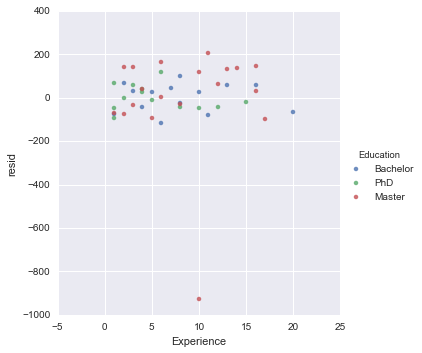

In [73]:
df['resid'] = interEM_lm.resid
sns.lmplot("Experience", "resid", hue="Education", data=df, fit_reg=False)

Hay un outlier claro que se puede eliminar para mejorar el modelo, o usar modelos robustos.

In [74]:
rlm_model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 Salary   No. Observations:                   46
Model:                            RLM   Df Residuals:                       39
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 21 Nov 2015                                         
Time:                        10:47:32                                         
No. Iterations:                    18                                         
                                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------

** Resumen **

Combinando `statsmodels` y `patsy` podemos realizar modelos estadísticos complejos añadiendo interacciones entre variables de distintas formas.

`statsmodels`, al ser una librería estadística, nos ofrece multitud de indicadores de significatividad y ajusde de los modelos que nos facilitan la detección de errores habituales como overfitting o colinearlidades. También permite identificar las variables más i menos importantes de los modelos.

`patsy`, como librería auxiliar, ofrece muchas posibilidades como son realizar la dummificación de variables y permite definir los modelos a partir de un lenguaje de fórmulas.

## ¿Y en producción?

 - Preferimos utilizar la librería `scikit` para producción
 - `statsmodels` (creemos que) es una librería muy académica
 - Aunque parecidos, cada librería tiene sus métodos de ajuste propios
 - Es posible encontrar equivalencias entre modelos de `scikit` y modelos de `statsmodels` (con pacicencia!)
 
Ejemplo:

** Modelo anterior en statsmodels **

In [75]:
y_regr, x_regr = dmatrices(formula_EM, df, return_type='dataframe')

regr_stm = sm.OLS(y_regr, x_regr).fit()
print(regr_stm.summary())
print('\n\nVariables y coeficientes en statsmodels \n')
print(regr_stm.params)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Sat, 21 Nov 2015   Prob (F-statistic):           1.67e-55
Time:                        10:47:32   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------

** Modelo anterior en scikit **

In [76]:
from sklearn.linear_model import LinearRegression

regr_skl = LinearRegression(fit_intercept=False)
regr_skl.fit(x_regr, y_regr)

/home/dukebody/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [77]:
for val, col in zip(regr_skl.coef_[0], x_regr.columns):
    print('%s \t %s' % (val, col))

9472.68544963 	 Intercept
3981.37689953 	 C(Management)[T.True]
1381.67063053 	 C(Education)[T.Master]
1730.74832283 	 C(Education)[T.PhD]
4902.52307086 	 C(Management)[T.True]:C(Education)[T.Master]
3066.0351249 	 C(Management)[T.True]:C(Education)[T.PhD]
496.987010592 	 Experience


** Comparación de resultados Regresión Lineal **

In [79]:
print('statsmodels \t scikit \t Diferencia \t Variable \n')
for v1, v2, c in zip(regr_stm.params, regr_skl.coef_[0], x_regr.columns):
    print('%+.4f \t %+.4f \t %+.4f \t %s' % (v1, v2, abs(v1-v2), c))

statsmodels 	 scikit 	 Diferencia 	 Variable 

+9472.6854 	 +9472.6854 	 +0.0000 	 Intercept
+3981.3769 	 +3981.3769 	 +0.0000 	 C(Management)[T.True]
+1381.6706 	 +1381.6706 	 +0.0000 	 C(Education)[T.Master]
+1730.7483 	 +1730.7483 	 +0.0000 	 C(Education)[T.PhD]
+4902.5231 	 +4902.5231 	 +0.0000 	 C(Management)[T.True]:C(Education)[T.Master]
+3066.0351 	 +3066.0351 	 +0.0000 	 C(Management)[T.True]:C(Education)[T.PhD]
+496.9870 	 +496.9870 	 +0.0000 	 Experience


** Resumen **

Los coeficientes de la regersión lineal son los mismos en `statsmodels` que en `scikit`,
ya que usan el mismo método de optimización (Ordinary Least Squares)

En otros casos encontrar la equivalencia es más complicado. 

** Otro ejemplo: Regresión Logística **

Vamos a predecir si es jefe o no en función de la experiencia y la educación

** `Management = f(Experience, Education)` **

** Preparación de la matriz de datos usando `patsy` **

In [80]:
#print df.head()
#formula_logit = 'Management ~ Experience + C(Education) + Salary'
formula_logit = 'Management ~ Experience + C(Education)'
y_logit_full, x_logit = dmatrices(formula_logit, df, return_type='dataframe')
y_logit = y_logit_full[y_logit_full.columns[1]] # Truco para quedarnos con la variable endogena que nos interessa
print(x_logit.head())
print(y_logit.head())

   Intercept  C(Education)[T.Master]  C(Education)[T.PhD]  Experience
0          1                       0                    0           1
1          1                       0                    1           1
2          1                       0                    1           1
3          1                       1                    0           1
4          1                       0                    1           1
0    1
1    0
2    1
3    0
4    0
Name: Management[True], dtype: float64


** Regresión Logística con statsmodels **

In [81]:
logit_stm = sm.Logit(y_logit, x_logit)
result_logit_stm = logit_stm.fit_regularized(method='l1', full_output=True, alpha=0.01)
print(result_logit_stm.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.658846192402
            Iterations: 42
            Function evaluations: 43
            Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:       Management[True]   No. Observations:                   46
Model:                          Logit   Df Residuals:                       42
Method:                           MLE   Df Model:                            3
Date:                Sat, 21 Nov 2015   Pseudo R-squ.:                 0.03817
Time:                        15:29:11   Log-Likelihood:                -30.290
converged:                       True   LL-Null:                       -31.492
                                        LLR p-value:                    0.4928
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------

** Regresión Logística con `scikit` **

In [82]:
from sklearn.linear_model import LogisticRegression
logit_skl_l2 = LogisticRegression(fit_intercept=False)
logit_skl_l2.fit(x_logit, y_logit)

for x,y in zip(logit_skl_l2.coef_[0], x_logit.columns):
    print("{}\t{}".format(x,y))

-0.26473069155700313	Intercept
-0.13940280488227713	C(Education)[T.Master]
0.609472275600617	C(Education)[T.PhD]
-0.012424290311584589	Experience


** Comparación de resultados Regresión Logística **

In [83]:
print('statsmodels \t scikit \t Diferencia \t Variable \n')
for v1, v2, c in zip(result_logit_stm.params, logit_skl_l2.coef_[0], x_logit.columns):
    print('%+.4f \t %+.4f \t %+.4f \t %s' % (v1, v2, abs(v1-v2), c))

statsmodels 	 scikit 	 Diferencia 	 Variable 

-0.5872 	 -0.2647 	 +0.3225 	 Intercept
+0.0369 	 -0.1394 	 +0.1763 	 C(Education)[T.Master]
+1.0480 	 +0.6095 	 +0.4386 	 C(Education)[T.PhD]
+0.0011 	 -0.0124 	 +0.0135 	 Experience


La Regresión Logística de `statsmodels` es `l1` y la regresión por defecto de `scikit` es `l2`.
Los resultados son muy distintos

** Regresión Logística `l1` con `scikit` **

In [84]:
from sklearn.linear_model import LogisticRegression
logit_skl = LogisticRegression(C=1.0 / 0.01, penalty='l1', fit_intercept=False)
#logit_skl = LogisticRegression(fit_intercept=False)
logit_skl.fit(x_logit, y_logit)

for x,y in zip(logit_skl.coef_[0], x_logit.columns):
    print("{}\t{}".format(x,y))

-0.5870043107756643	Intercept
0.03686113917422941	C(Education)[T.Master]
1.047884440481308	C(Education)[T.PhD]
0.0010624932382406296	Experience


** Comparación de resultados Regresión Logística `l1` **

In [85]:
print('statsmodels \t scikit \t Diferencia \t Variable \n')
for v1, v2, c in zip(result_logit_stm.params, logit_skl.coef_[0], x_logit.columns):
    print('%+.4f \t %+.4f \t %+.4f \t %s' % (v1, v2, abs(v1-v2), c))

statsmodels 	 scikit 	 Diferencia 	 Variable 

-0.5872 	 -0.5870 	 +0.0002 	 Intercept
+0.0369 	 +0.0369 	 +0.0001 	 C(Education)[T.Master]
+1.0480 	 +1.0479 	 +0.0002 	 C(Education)[T.PhD]
+0.0011 	 +0.0011 	 +0.0000 	 Experience


Ahora sí :-)
Los resultados obtenidos con las dos librerías son muy parecidos 

** Resumen **

En el caso de otros métodos de predicción más complejos, como la Regresión Logística, se puede buscar la equivalencia entre los métodos de `statsmodels` y de `scikit` que sean comunes a los dos.

Una vez encontrados, como en el caso que hemos visto, nos será posible desarrollar los modelos con la librería estadística y ponerlos en producción con la de Machine Learning, sacando provecho de las cualidades de los dos.

# Más features de statsmodels
 - Generalized Linear Models: $y = g(\sum x_i \beta_i)$
 - Robust Linear Models: intentan evitar efectos nocivos de outliers automáticamente
 - Time series analysis: modelos autoregresivos
 - Utilidades: más tests estadísticos y plots

## ¡¡¡Muchas gracias por vuestra atención!!!
<img src="http://globalprioritiesproject.org/wp-content/uploads/2015/09/hiring_graphic.jpeg" style="width:300px">

<img src="http://www.forodefotos.com/attachments/fotos-graciosas/34302d1338949327-alumnos-durmiendo-durmiendo-en-clase.jpg" style="display:none">


 - `israel@lead-ratings.com`
 - `miquel.camprodon@kernel-analytics.com`


## ¿Alguna pregunta?